In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn

# Environment

In [2]:
from numpy.random import RandomState
from scipy.stats import truncnorm


def sample_mixture_truncnorm(n: int, random_state: RandomState = None) -> np.array:
    if random_state is None:
        random_state = RandomState()

    scale = 0.1

    loc = -0.6
    a, b = (-1.0 - loc) / scale, (1.0 - loc) / scale
    pos_samples = truncnorm.rvs(
        a, b, loc=loc, scale=scale, size=2 * n, random_state=random_state
    )

    loc = 0.6
    a, b = (-1.0 - loc) / scale, (1.0 - loc) / scale
    neg_samples = truncnorm.rvs(
        a, b, loc=loc, scale=scale, size=2 * n, random_state=random_state
    )

    all_samples = np.concatenate([pos_samples, neg_samples], axis=None)
    random_state.shuffle(all_samples)

    return all_samples.reshape((-1, 2))[:n]

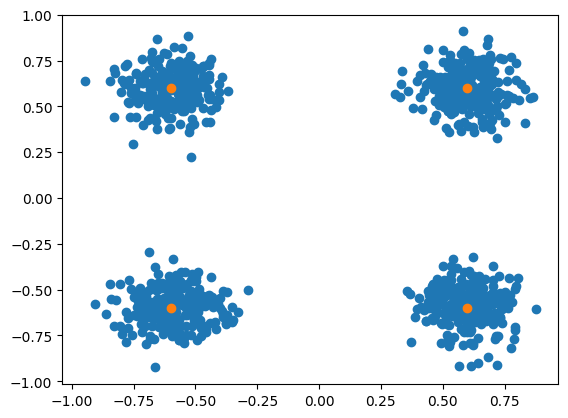

In [3]:
data = sample_mixture_truncnorm(1000)
plt.scatter(data[:, 0], data[:, 1])
plt.scatter([0.6, 0.6, -0.6, -0.6], [0.6, -0.6, 0.6, -0.6])

# Naive K-Means++

In [4]:
from sklearn.cluster import KMeans

data1 = sample_mixture_truncnorm(100)
data2 = sample_mixture_truncnorm(100)
kmeans1 = KMeans(n_clusters=3).fit(data1)
kmeans2 = KMeans(n_clusters=3).fit(data2)

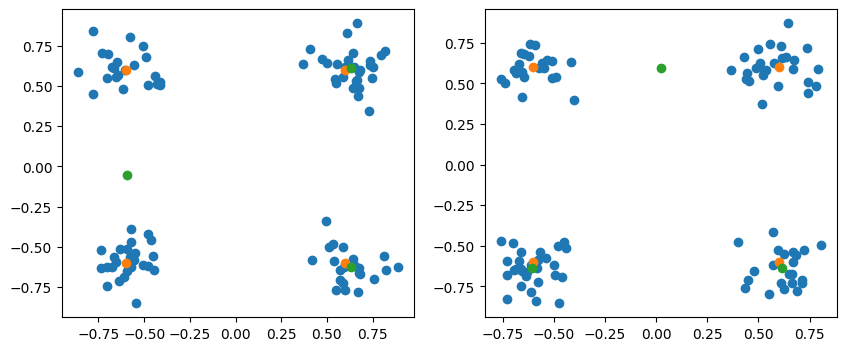

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(data1[:, 0], data1[:, 1])
ax[0].scatter([0.6, 0.6, -0.6, -0.6], [0.6, -0.6, 0.6, -0.6])
ax[0].scatter(kmeans1.cluster_centers_[:, 0], kmeans1.cluster_centers_[:, 1])

ax[1].scatter(data2[:, 0], data2[:, 1])
ax[1].scatter([0.6, 0.6, -0.6, -0.6], [0.6, -0.6, 0.6, -0.6])
ax[1].scatter(kmeans2.cluster_centers_[:, 0], kmeans2.cluster_centers_[:, 1])

# Replicable K-Means++

## Replicable Heavy Hitters

In [6]:
from numpy.random import RandomState


def get_idx_intersect(A, B):
    return (A[:, None] == B).all(-1).any(1)


# 1-dimensional
def r_heavy_hitters(
    sampler, thres: float, eps: float, rho: float, random_state: RandomState = None
):
    print("r_heavy_hitters...")
    assert 0 < thres < 1
    assert 0 < eps < thres

    if random_state is None:
        random_state = RandomState()

    n1 = int(np.ceil(np.log(5 / (rho * (thres - eps))) / (thres - eps)))
    print(n1)
    candidates = sampler(size=n1)
    candidates = np.unique(candidates, axis=0)

    n2 = int(
        np.ceil(
            (np.log(5 / rho) + (np.sqrt(n1) + 1) * np.log(2))  # * 50
            / (rho**2 * eps**2) / 1e2
        )
    )
    print(n2)
    samples = sampler(size=n2)

    unique_samples, count = np.unique(samples, axis=0, return_counts=True)
    count = count.astype(float) / n2

    rand_thres = random_state.uniform(thres - eps, thres)
    print(count, rand_thres, n1 + n2)

    # magic intersection https://stackoverflow.com/a/67113105
    # get_idx_intersect(unique_samples, candidates)
    _, idx_intersect, _ = np.intersect1d(unique_samples, candidates, return_indices=True)
    
    unique_samples_intersect = unique_samples[idx_intersect]
    count_intersect = count[idx_intersect]
    return unique_samples_intersect[count_intersect >= rand_thres]

In [7]:
def toy_sampler(size: int, random_state: RandomState = None):
    if random_state is None:
        random_state = RandomState()

    return np.random.choice([0, 1, 2], p=[0.3, 0.3, 0.4], size=size).reshape((-1, 1))


print(
    r_heavy_hitters(
        toy_sampler, thres=0.4, eps=0.1, rho=0.3, random_state=RandomState(2)
    )
)
print(
    r_heavy_hitters(
        toy_sampler, thres=0.4, eps=0.1, rho=0.3, random_state=RandomState(2)
    )
)

r_heavy_hitters...
14
68
[0.30882353 0.25       0.44117647] 0.3435994902142004 82
[[2]]
r_heavy_hitters...
14
68
[0.29411765 0.36764706 0.33823529] 0.3435994902142004 82
[[1]]


## Replicable Coreset

In [8]:
class QuadTreeNode:
    def __init__(
        self, point: np.array, radius: float, is_heavy: bool = False, parent=None
    ):
        self.point = point
        self.radius = radius
        self.is_heavy = is_heavy
        self.children = []
        self.parent = parent


def make_children(nodes):
    child_nodes = []
    for node in nodes:
        radius = node.radius
        d = (radius / 2, -radius / 2)
        for dx in d:
            for dy in d:
                next_point = np.copy(node.point)
                # print(next_point)
                next_point[0] += dx
                next_point[1] += dy

                child_node = QuadTreeNode(next_point, radius / 2, parent=node)
                node.children.append(child_node)

                child_nodes.append(child_node)

    return child_nodes


def get_idx_sampler(sampler, nodes):
    def _idx_sampler(size: int):
        samples = sampler(size)
        idx_samples = [len(nodes)] * size
        for i in range(size):
            for j in range(len(nodes)):
                if (
                    np.linalg.norm(samples[i] - nodes[j].point, ord=np.inf)
                    <= nodes[j].radius
                ):
                    idx_samples[i] = j
        return idx_samples

    return _idx_sampler

In [9]:
from numpy.random import RandomState


def r_quad_tree(
    sampler,
    k,
    eps,
    rho,
    Gamma,
    beta,
    Delta=np.sqrt(2),
    random_state: RandomState = None,
):
    assert 0 < eps < 1
    assert 0 < rho < 1

    t = 3  # int(np.ceil(1 / 2 * np.log(5 * Delta**2 / (eps * Gamma)) + 1))
    M = (Delta / eps) ** 2 # * 2**10
    gamma = eps / (t * k * M * Delta**2) # / 20
    print(t, M, gamma)

    # build quad-tree
    root = QuadTreeNode(point=np.array([0.0, 0.0]), radius=1.0, is_heavy=True)
    H = [root]
    i = 1
    while H:
        print(i)
        if (2 ** (-i + 1) * Delta) ** 2 <= eps * Gamma / 5:
            break

        child_nodes = make_children(H)
        idx_sampler = get_idx_sampler(sampler, child_nodes)
        thres = gamma * Gamma * 2 ** (2 * i)
        heavy_hitters = r_heavy_hitters(
            idx_sampler,
            thres=thres,
            eps=thres / 2,
            rho=rho / t,
            random_state=random_state,
        )

        H = []
        for idx in heavy_hitters:
            if idx < len(child_nodes):
                child_nodes[idx].is_heavy = True
                H.append(child_nodes[idx])

        i += 1

    return root

In [10]:
root1 = r_quad_tree(
    sample_mixture_truncnorm,
    k=4,
    eps=0.99,
    rho=0.3,
    Gamma=0.5,
    beta=1.0,
    Delta=np.sqrt(2),
    random_state=RandomState(2),
)

root2 = r_quad_tree(
    sample_mixture_truncnorm,
    k=4,
    eps=0.99,
    rho=0.3,
    Gamma=0.5,
    beta=1.0,
    Delta=np.sqrt(2),
    random_state=RandomState(2),
)

3 2.040608101214162 0.02021456249999999
1
r_heavy_hitters...
387
44640
[0.25013441 0.25190412 0.24778226 0.25017921] 0.029028008699030907 45027
2
r_heavy_hitters...
80
1653
[0.16333938 0.03932244 0.02540835 0.00544465 0.04053237 0.18209316
 0.00846945 0.03448276 0.02964307 0.00604961 0.18451301 0.0369026
 0.00423472 0.03629764 0.03750756 0.16575923] 0.08295459973469756 1733
3
r_heavy_hitters...
16
71
[0.22535211 0.08450704 0.02816901 0.12676056 0.02816901 0.1971831
 0.01408451 0.02816901 0.26760563] 0.5012119842077443 87
3 2.040608101214162 0.02021456249999999
1
r_heavy_hitters...
387
44640
[0.24973118 0.2530914  0.24887993 0.24829749] 0.029028008699030907 45027
2
r_heavy_hitters...
80
1653
[0.17604356 0.03750756 0.03085299 0.00423472 0.02903811 0.17301875
 0.00725953 0.02903811 0.03508772 0.00544465 0.17906836 0.03448276
 0.00725953 0.02903811 0.0399274  0.18269812] 0.08295459973469756 1733
3
r_heavy_hitters...
16
71
[0.01408451 0.18309859 0.01408451 0.09859155 0.02816901 0.04225352
 

In [11]:
def dfs(root):
    heavy_nodes = []

    def explore(node):
        if not node.is_heavy:
            return
        
        heavy_nodes.append(node.point.reshape((1, -1)))
        for child in node.children:
            explore(child)
    
    explore(root)
    return np.concatenate(heavy_nodes, axis=0)
        
heavy_nodes1 = dfs(root1)
heavy_nodes2 = dfs(root2)

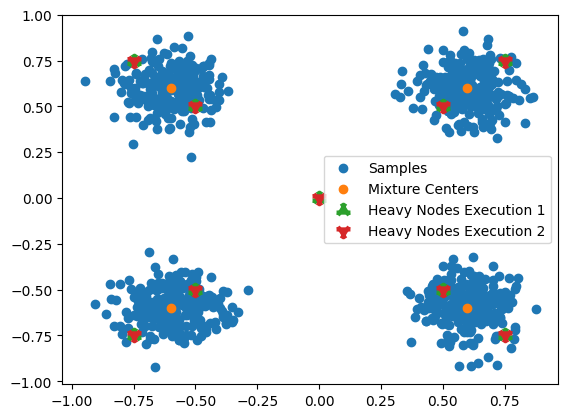

In [12]:
plt.scatter(data[:, 0], data[:, 1], label="Samples")
plt.scatter([0.6, 0.6, -0.6, -0.6], [0.6, -0.6, 0.6, -0.6], label="Mixture Centers")
plt.scatter(heavy_nodes1[:, 0], heavy_nodes1[:, 1], marker="1", linewidths=10, label="Heavy Nodes Execution 1")
plt.scatter(heavy_nodes1[:, 0], heavy_nodes1[:, 1], marker="2", linewidths=10, label="Heavy Nodes Execution 2")

plt.legend()
plt.show()